In [188]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#/content/drive/Shared drives/Data Mining Project/Image data

Mounted at /content/drive


In [189]:
#set up the shared drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
#import libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
# Set some parameters

train_dir = '/content/drive/Shared drives/Data Mining Project/V2_Plant_Seedling_Data (Personal_Copy)/train'
test_dir = '/content/drive/Shared drives/Data Mining Project/Files for Submission/Google_Test_Data'
sample_submission = pd.read_csv('/content/drive/Shared drives/Data Mining Project/V2_Plant_Seedling_Data (Personal_Copy)/test_new.csv')

In [ ]:
#Getting the number of train samples for the seedling species
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
          'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
          'Small-flowered Cranesbill', 'Sugar beet']
for species in SPECIES:
  print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [ ]:
#Determine the shape of the train data
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['/content/drive/Shared drives/Data Mining Project/V2_Plant_Seedling_Data (Personal_Copy)/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)


Training Data:  (4750, 3)


In [191]:
#Create masks for the image using OpenCV by identifying the green color in the pitcure
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
#Segment the plant images
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
#Sharpen the image(Optional. The code will work without this step as well)
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
%%time
#Mask the train iamges
x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 1min 15s, sys: 5.08 s, total: 1min 21s
Wall time: 19min 54s


In [ ]:
x_train.shape

(4750, 256, 256, 4)

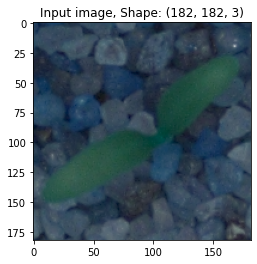

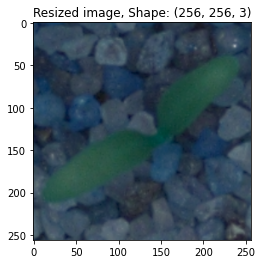

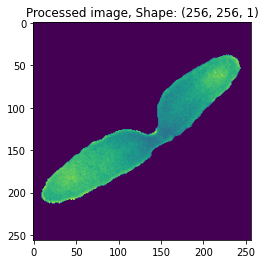

In [ ]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()


In [ ]:
#encode the labels
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [ ]:
#Split the data into tarin and test. 90% traina dn 10% test
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [ ]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [192]:
#Apply CNN model
model = Sequential()

input_shape = (256, 256, 4)

model.add(Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))

model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 64)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 128)      

In [193]:
#Compile the model using Adam optimizer
model.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Reduce the learning rate when on plateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [ ]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

NameError: ignored

In [ ]:
#define epoch and batch size
batch_size = 32
epochs = 40

In [ ]:
#Train the model! Please do not run this step unless you wan to train from scratch. Will take several hours to train
#history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  #validation_data = (x_val,y_val), verbose = 1, 
                                  #steps_per_epoch=x_train.shape[0] // batch_size, 
                                  #callbacks=[learning_rate_reduction])

In [194]:
#Load the saved model. Avoids training the model again and again!
model.load_weights('/content/drive/Shared drives/Data Mining Project/cnn_trained_model.h5')

In [195]:
%%time
#Mask the test images
test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['/content/drive/Shared drives/Data Mining Project/Files for Submission/Google_Test_Data/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)


                                                file
0  /content/drive/Shared drives/Data Mining Proje...
1  /content/drive/Shared drives/Data Mining Proje...
2  /content/drive/Shared drives/Data Mining Proje...
3  /content/drive/Shared drives/Data Mining Proje...
4  /content/drive/Shared drives/Data Mining Proje...
CPU times: user 598 ms, sys: 46.1 ms, total: 644 ms
Wall time: 659 ms


In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


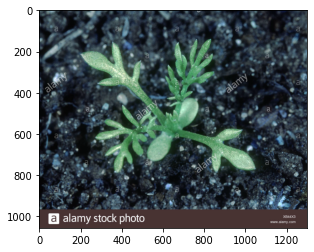

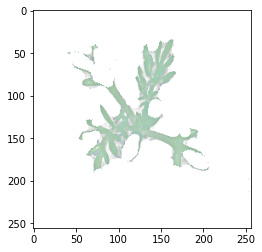

In [197]:
#Call the mask functions for test images
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()


In [ ]:
#Compute the accuracy for the test set
score = model.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

15/15 [==============================] - 76s 5s/step - loss: 0.1842 - accuracy: 0.9305
Accuracy on Validation Set 0.9305263161659241


In [ ]:
#Compute the accuracy on the train set
score = model.evaluate(x_train,y_train)
print('Accuracy on Train Set',score[1])

134/134 [==============================] - 669s 5s/step - loss: 0.1859 - accuracy: 0.9406
Accuracy on Train Set 0.9405847787857056


In [198]:
#Predict the labels
Pred_labels = np.argmax(model.predict(x_test),axis = 1)

In [ ]:
#Submit the results in a csv file
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('/content/drive/Shared drives/Data Mining Project/V2_Plant_Seedling_Data (Personal_Copy)/submit_results.csv', index=False)
print(submission.head())

            file   species
0  3c75e7d79.png  Charlock
1        456.jpg   Fat Hen
2        789.jpg  Charlock
3        123.jpg   Fat Hen
4     131415.jpg  Charlock


In [204]:
%%writefile app.py
import streamlit as st
from keras.preprocessing import image
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
import os
import cv2
import numpy as np
import 

st.set_option('deprication.showfilwUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def load_model():
  model=model.load_weights('/content/drive/Shared drives/Data Mining Project/cnn_trained_model.h5')
  return model
model=load_model()
st.write('''
         # Plant Seedling Classification
         ''')
file=st.file_uploader("Please upload a seedling image,type=["jpg","png"])
def import_and_predict(image_data, model):
    
        size = (256,256)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(256,256),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img_resize[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, model)
    
    if np.argmax(prediction) == 0:
        st.write("It is a paper!")
    elif np.argmax(prediction) == 1:
        st.write("It is a rock!")
    else:
        st.write("It is a scissor!")
    
    st.text("Probability (0: Paper, 1: Rock, 2: Scissor")
    st.write(prediction)


Overwriting app.py


In [223]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'
nohup: failed to run command 'streamlit': No such file or directory


In [210]:
!ngrok authtoken 1gtL7GkgZjuAL80eWPnDNi0erAE_Nsum1sPA94eAYQPCXmsS

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [213]:
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')
public_url

'http://15c7839bdfd7.ngrok.io'

In [215]:
!cat nohup.out

In [ ]:
!ngrok http 111

Your account 'Narasimha Kamath Ardi' is limited to 1 simultaneous ngrok client session.
Active ngrok client sessions in region 'us':
  - ts_1gtPwN51z6akiChjmlLGRztnug6 (104.197.186.150)

ERR_NGROK_108



In [ ]:
!pgrep streamlit

In [ ]:
ngrok.kill()

In [212]:
!killall ngrok